# Homework 1: Neural Networks from Scratch (Problems 4, 5, 6)

**CS-GY 6953 Deep Learning | Spring 2026**

--- 

## Overview

This notebook contains the starter code for Problems 4, 5, and 6 of Homework 1. 

**Objectives:**
1.  **Problem 4 (15 pts):** Train an MLP on the BloodMNIST medical dataset and perform detailed error analysis.
2.  **Problem 5 (15 pts):** Investigate the impact of weight initialization on training dynamics and activation statistics.
3.  **Problem 6 (25 pts):** Build a small modular neural network library (`mytorch`) from scratch using NumPy and train it on MNIST.

## Submission Instructions

1.  **Complete the code**: Fill in all `TODO` blocks in this notebook and in the `mytorch/` Python files.
2.  **Run all cells**: Ensure all outputs, plots, and analyses are visible.
3.  **Export/Zip**: Zip this notebook and the `mytorch/` folder together.

## Academic Integrity

You may discuss concepts with classmates, but all code and written analysis must be your own. Your experimental results (accuracies, confusion matrices, plots) 
should reflect your actual training runs. Do not fabricate or copy results.


--- 
## Setup

First, we install the necessary packages. We will use `medmnist` for Problem 4.

In [1]:
!pip install medmnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import medmnist
from medmnist import INFO, Evaluator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Setup

**BloodMNIST**: This dataset will be automatically downloaded by the `medmnist` library when you run the code in Problem 4.

**MNIST**: This dataset (used in Problems 5 and 6) will be downloaded to the `./data` directory by `torchvision` in the cell below. 
Please ensure you have an internet connection.

In [3]:
# Download MNIST data (used in Problems 5 and 6)
import os

# Create data directory
os.makedirs('./data', exist_ok=True)

print("Downloading MNIST...")
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("MNIST Ready.")

MNIST Ready.


# Problem 1: Softmax + Matrix Gradients


## 1.1: Temperature-Scaled Softmax Jacobian

### Compute the partial derivative

Jacobian entry
$$
\frac{\partial y_i}{\partial z_k}
= \frac{\partial}{\partial z_k}
\left( \frac{e^{z_i/\tau}}{S} \right)
$$
using the quotient rule:
$$
\frac{\partial y_i}{\partial z_k}
=
\frac{
\left(\frac{\partial}{\partial z_k} e^{z_i/\tau}\right) S
-
e^{z_i/\tau} \left(\frac{\partial S}{\partial z_k}\right)
}{S^2}.
$$

Compute each derivative:
$$
\frac{\partial}{\partial z_k} e^{z_i/\tau}
=
\frac{1}{\tau} e^{z_i/\tau}\,\mathbf{1}[i=k],
$$
$$
\frac{\partial S}{\partial z_k}
=
\frac{1}{\tau} e^{z_k/\tau}.
$$

Substitute:
$$
\frac{\partial y_i}{\partial z_k}
=
\frac{
\frac{1}{\tau} e^{z_i/\tau}\,\mathbf{1}[i=k]\, S
-
\frac{1}{\tau} e^{z_i/\tau} e^{z_k/\tau}
}{S^2}.
$$

Factor:
$$
\frac{\partial y_i}{\partial z_k}
=
\frac{1}{\tau}
\frac{e^{z_i/\tau}}{S^2}
\left(
\mathbf{1}[i=k]\, S - e^{z_k/\tau}
\right).
$$

Using $y_i = \frac{e^{z_i/\tau}}{S}$ and $y_k = \frac{e^{z_k/\tau}}{S}$, we get
$$
\frac{\partial y_i}{\partial z_k}
=
\frac{1}{\tau}
\left(
\mathbf{1}[i=k]\, y_i - y_i y_k
\right).
$$

---

### Matrix form

Let $\mathrm{diag}(y)$ be the diagonal matrix with entries $y_i$, and let $yy^\top$ be the outer product. Then
$$
J_{ik}
=
\frac{1}{\tau}
\left(
(\mathrm{diag}(y))_{ik}
-
(yy^\top)_{ik}
\right).
$$

The Jacobian can be written as
$$
\boxed{
\frac{\partial y}{\partial z}
=
\frac{1}{\tau}
\left(
\mathrm{diag}(y) - yy^\top
\right)
}
$$


## 1.2: Gradient w.r.t. $A$ and $b$ in an affine least-squares objective

Define the residual
$$
r \;=\; Ax+b-t \in \mathbb{R}^d,
\quad\text{so}\quad
f(A,b)=\frac12\, r^\top r.
$$

---

### Gradient w.r.t. $b$

$dr = db$. Then
$$
df = r^\top dr = r^\top db.
$$
So the gradient is
$$
\nabla_b f \;=\; r \;=\; Ax+b-t.
$$

---

### Gradient w.r.t. $A$

$dr = dA\,x$. Then
$$
df = r^\top dr = r^\top (dA\,x).
$$
Rewrite as a trace:
$$
r^\top (dA\,x) = \mathrm{tr}\!\left(r^\top dA\,x\right)
= \mathrm{tr}\!\left(x\,r^\top dA\right)
= \langle r x^\top,\; dA\rangle_F.
$$
Therefore,
$$
\nabla_A f \;=\; r x^\top \;=\; (Ax+b-t)\,x^\top.
$$

---

### Final answer
$$
\boxed{\nabla_A f = (Ax+b-t)\,x^\top}
\qquad
\boxed{\nabla_b f = Ax+b-t}
$$


## 1.3 Softmax vs. Sigmoid when and why?

Softmax is better for single label classification like recognizing digits, where only 1 class is correct. The outputs should compete so the probabilities sum to 1. It represents a categorical distribution and should be paired with cross-entropy loss.

Sigmoid is better for multi-label problems such as image tagging, where multiple labels can be true at the same time. It represents independent probabilities and is paried with binary cross-entropy loss.

# Problem 2: Linear Regression with Huber Loss

## 2.1: Gradient Derivation


The residual is
$$
r_i(w) = y_i - w^\top x_i.
$$

The objective is
$$
L_\delta(w) = \sum_{i=1}^n \ell_\delta(r_i(w)).
$$

Using the chain rule,
$$
\nabla_w L_\delta(w)
= \sum_{i=1}^n \ell_\delta'(r_i(w)) \, \nabla_w r_i(w).
$$

Since
$$
\nabla_w r_i(w) = -x_i,
$$
and the derivative of the Huber loss is
$$
\ell_\delta'(r) =
\begin{cases}
r & |r| \le \delta \\
\delta \, \mathrm{sign}(r) & |r| > \delta,
\end{cases}
$$
we obtain
$$
\nabla_w L_\delta(w)
=
-\sum_{i=1}^n
\begin{cases}
r_i(w)\, x_i & |r_i(w)| \le \delta \\
\delta\, \mathrm{sign}(r_i(w))\, x_i & |r_i(w)| > \delta.
\end{cases}
$$

## 2.2: Optimal w: closed form or not?

No, Huber loss usually does not give a single closed-form solution like ordinary least squares. The loss changes behavior depending on whether each residual is small or large, so you can’t write one fixed set of normal equations that holds for all data points at the same time. You must solve it numerically, commonly with an optimizer like (stochastic) gradient descent.

## 2.3: Add L_2 Regularization

The regularized objective is
$$
\tilde L(w) = \sum_{i=1}^n \ell_\delta(r_i(w)) + \frac{\lambda}{2}\|w\|_2^2.
$$

Taking the gradient gives
$$
\nabla_w \tilde L(w)
= \nabla_w L_\delta(w) + \lambda w.
$$

Substituting the gradient from part (2.1),
$$
\nabla_w \tilde L(w)
=
-\sum_{i=1}^n
\begin{cases}
r_i(w)\, x_i & |r_i(w)| \le \delta \\
\delta\, \mathrm{sign}(r_i(w))\, x_i & |r_i(w)| > \delta
\end{cases}
+ \lambda w.
$$


## 2.4: ML Pipeline Reflection: 

Huber changes optimization because it behaves like squared loss for small errors (smooth, fast convergence) but like absolute loss for big errors (limits how much outliers can dominate the gradient), so training is more stable with noisy data. For evaluation robustness, using a Huber-style objective makes your fitted model less sensitive to extreme points, so performance reflects the typical data better when outliers exist. Compared to squared loss, it trades a bit of sensitivity on clean data for much better behavior when there are outliers or heavy noise.

# Problem 3: Adam v.s. SGD with Momentum

## 3.1: Compute the First Two Adam Updates Explicitly

Adam (scalar):
$$
m_t=\beta_1 m_{t-1}+(1-\beta_1)g_t,\quad
v_t=\beta_2 v_{t-1}+(1-\beta_2)g_t^2
$$
Bias correction:
$$
\hat m_t=\frac{m_t}{1-\beta_1^t},\quad
\hat v_t=\frac{v_t}{1-\beta_2^t}
$$
Update:
$$
w_{t+1}=w_t-\alpha\frac{\hat m_t}{\sqrt{\hat v_t}+\epsilon}
$$

Assume $m_0=0$, $v_0=0$.

---

### Step 1 (gradient $g_1$)

$$
m_1=(1-\beta_1)g_1,\quad
v_1=(1-\beta_2)g_1^2
$$
$$
\hat m_1=g_1,\quad
\hat v_1=g_1^2
$$
$$
w_2=w_1-\alpha\frac{g_1}{|g_1|+\epsilon}
$$

---

### Step 2 (gradient $g_2$)

$$
m_2=(1-\beta_1)(\beta_1 g_1+g_2),\quad
v_2=(1-\beta_2)(\beta_2 g_1^2+g_2^2)
$$
$$
\hat m_2=\frac{\beta_1 g_1+g_2}{1+\beta_1},\quad
\hat v_2=\frac{\beta_2 g_1^2+g_2^2}{1+\beta_2}
$$
$$
w_3=w_2-\alpha\frac{\hat m_2}{\sqrt{\hat v_2}+\epsilon}
$$


## 3.2: Compare to Momentum SGD Update Form

(a) In momentumg SGD, step size is basically set by the learning rate, so it does not automatically shrink when gradients are large or grow when they’re small. In Adam,it divides by a running estimate of gradient magnitude, so parameters with consistently large gradients get smaller effective steps.

Yes for Adam, no for momentum SGD.

(b) Momentum SGD updates scale by c, so steps get c times bigger/smaller. Adam mostly cancels out because both the numerator (first moment) and denominator (sqrt of second moment) scale with c, so the update magnitude is roughly invariant.

(c) ϵ prevents division by zero (or tiny numbers) and stabilizes training early on or when gradients are sparse, so the denominator never becomes dangerously small.

## 3.3: Short Explanation: Noisy Gradients + Sparse Features

Adam adapts the learning rate per parameter, using the history of squared gradients, while momentum SGD uses one global learning rate for everything. Because of this, Adam tends to be more stable with noisy gradients, since the second-moment normalization dampens erratic updates. For sparse or rarely-updated features, Adam often makes larger effective updates when a feature gets a gradient, which can help learning those rare parameters faster. Momentum SGD can work well too, but it often needs more careful learning-rate tuning to handle both frequent and rare features at once.

--- 
# Problem 4: Blood Cell Classification with MLPs (15 points)

In this problem, you will train a multi-layer perceptron (MLP) to classify microscopy images of blood cells using the **BloodMNIST** dataset.

### Q4.1: Data Loading and Exploration (2 points)

In [4]:
# TODO: Load BloodMNIST dataset
current_data_flag = 'bloodmnist'
info = INFO[current_data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
class_labels = info['label']
info['label']['3'] = 'immature granulocytes'

DataClass = getattr(medmnist, info['python_class'])

# Define transforms (convert to tensor and normalize)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load train, validation, and test sets
# download=True ensures it is downloaded if not present
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# TODO: Report number of samples
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 11959
Val samples: 1712
Test samples: 3421


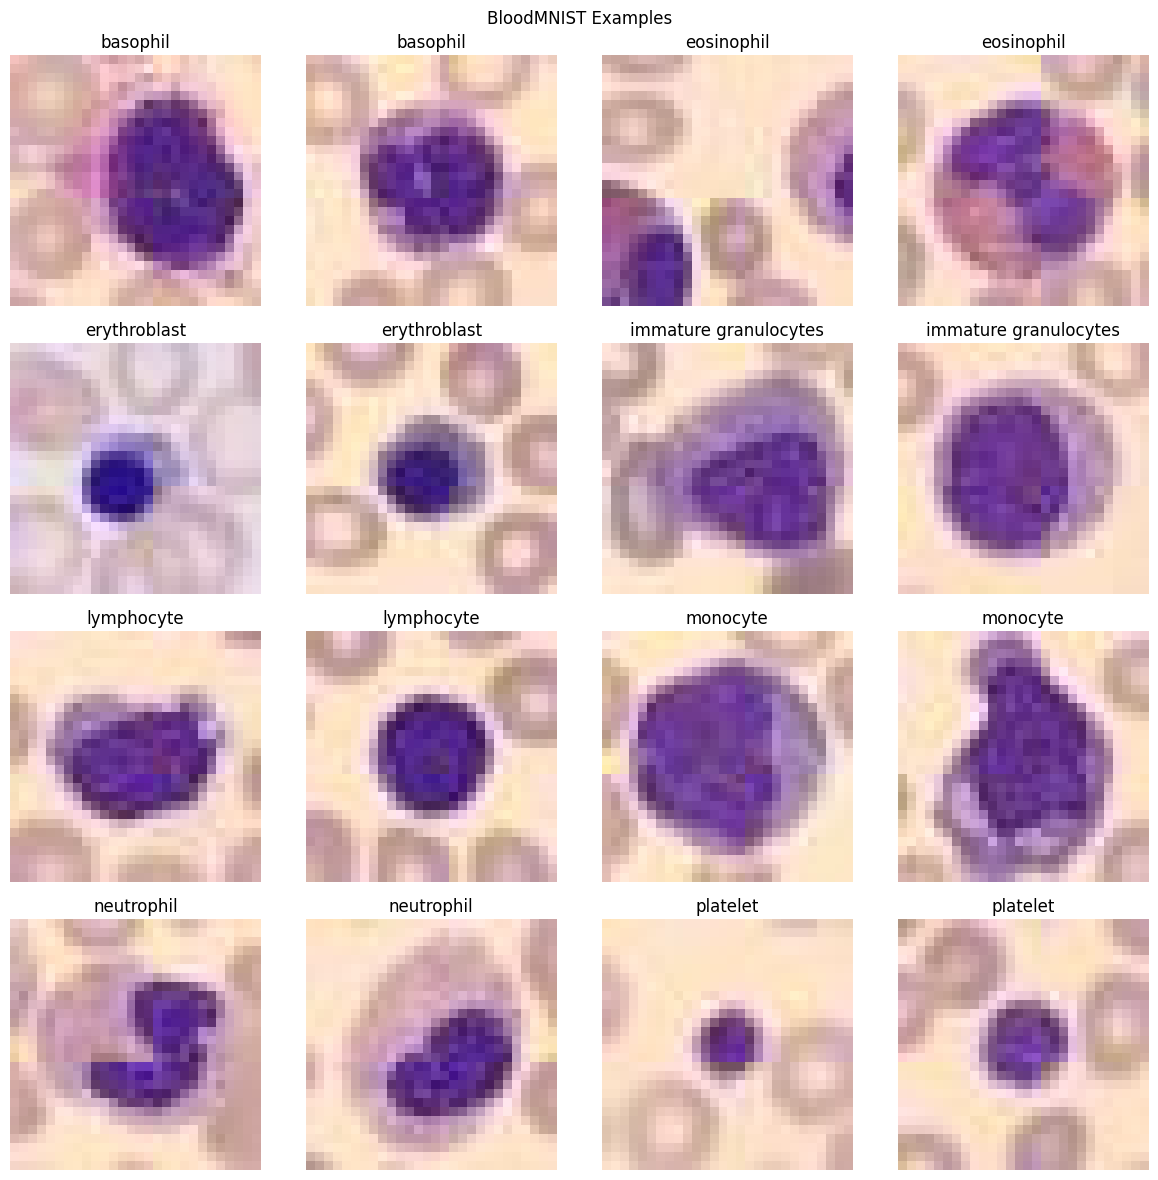

In [5]:
# TODO: Display a grid of 16 random training images (2 per class)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
class_images = {k: [] for k in range(n_classes)}
samples_found = 0

# Iterate through the loader to collect 2 examples per class
for images, labels in train_loader:
    labels = labels.cpu().numpy().flatten()
    images = images.cpu()
    
    for i in range(len(labels)):
        label = labels[i]
        if len(class_images[label]) < 2:
            # Denormalize: (image * 0.5) + 0.5
            img = images[i] * 0.5 + 0.5
            img = img.permute(1, 2, 0) # Convert (C, H, W) to (H, W, C)
            class_images[label].append(img)
            
    # Stop once we have 2 images for every class
    if all(len(v) == 2 for v in class_images.values()):
        break

# Plot the images
idx = 1
for label in range(n_classes):
    for img in class_images[label]:
        plt.subplot(4, 4, idx)
        plt.imshow(img)
        plt.title(info['label'][str(label)]) 
        plt.axis('off')
        idx += 1

plt.suptitle("BloodMNIST Examples")
plt.tight_layout()
plt.show()

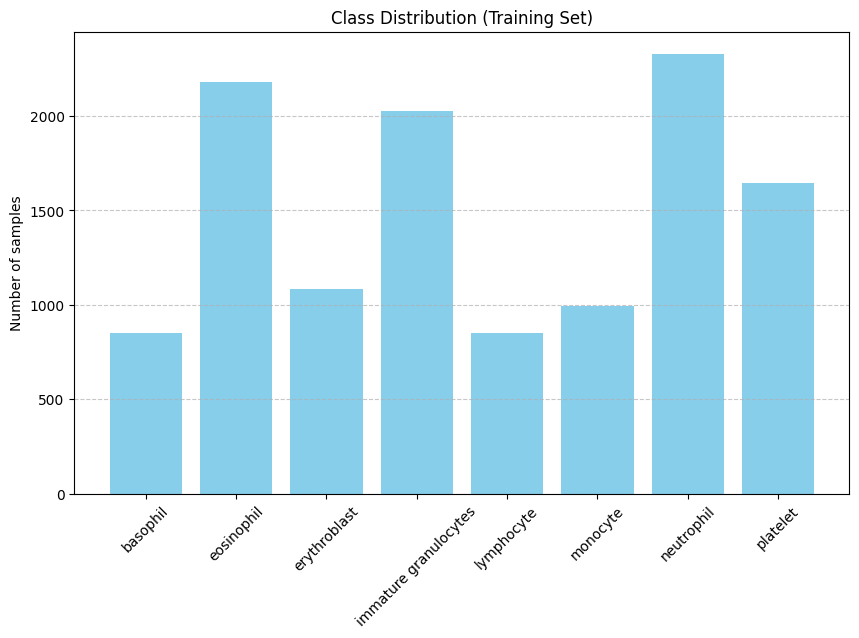

In [6]:
# TODO: Plot the class distribution (bar chart) for the training set
# Count occurrences of each class index in train_dataset.labels
from collections import Counter

all_labels = train_dataset.labels.flatten()
counts = Counter(all_labels)

class_names = [info['label'][str(i)] for i in range(n_classes)]
values = [counts[i] for i in range(n_classes)]
plt.figure(figsize=(10, 6))
plt.bar(class_names, values, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Number of samples')
plt.title("Class Distribution (Training Set)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Question:** Is the dataset balanced? 

No, the dataset is not balanced. The number of samples varies significantly across the 8 classes.

### Q4.2: Build and Train an MLP (5 points)

Architecture:
*   Input: 2352 (flattened 28x28x3)
*   Hidden 1: 256 (ReLU)
*   Hidden 2: 128 (ReLU)
*   Output: 8

In [7]:
class BloodMLP(nn.Module):
    def __init__(self):
        super(BloodMLP, self).__init__()
        # TODO: Define layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 3, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        # TODO: Implement forward pass
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# TODO: Initialize model, optimizer (Adam, lr=1e-3), and loss function (CrossEntropy)
model = BloodMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [9]:
# TODO: Training Loop
num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long() 
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze().long()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

Epoch 1/30 - Train Loss: 0.8943 Acc: 0.6754 | Val Loss: 0.6091 Acc: 0.7780
Epoch 2/30 - Train Loss: 0.6013 Acc: 0.7831 | Val Loss: 0.5159 Acc: 0.8271
Epoch 3/30 - Train Loss: 0.5249 Acc: 0.8104 | Val Loss: 0.4844 Acc: 0.8213
Epoch 4/30 - Train Loss: 0.4645 Acc: 0.8295 | Val Loss: 0.4607 Acc: 0.8259
Epoch 5/30 - Train Loss: 0.4390 Acc: 0.8394 | Val Loss: 0.4682 Acc: 0.8324
Epoch 6/30 - Train Loss: 0.3928 Acc: 0.8531 | Val Loss: 0.4211 Acc: 0.8370
Epoch 7/30 - Train Loss: 0.3823 Acc: 0.8585 | Val Loss: 0.3953 Acc: 0.8528
Epoch 8/30 - Train Loss: 0.3583 Acc: 0.8691 | Val Loss: 0.4206 Acc: 0.8429
Epoch 9/30 - Train Loss: 0.3390 Acc: 0.8767 | Val Loss: 0.4391 Acc: 0.8359
Epoch 10/30 - Train Loss: 0.3249 Acc: 0.8818 | Val Loss: 0.4322 Acc: 0.8446
Epoch 11/30 - Train Loss: 0.2968 Acc: 0.8920 | Val Loss: 0.4568 Acc: 0.8376
Epoch 12/30 - Train Loss: 0.2920 Acc: 0.8946 | Val Loss: 0.3728 Acc: 0.8709
Epoch 13/30 - Train Loss: 0.2701 Acc: 0.9003 | Val Loss: 0.3788 Acc: 0.8668
Epoch 14/30 - Train L

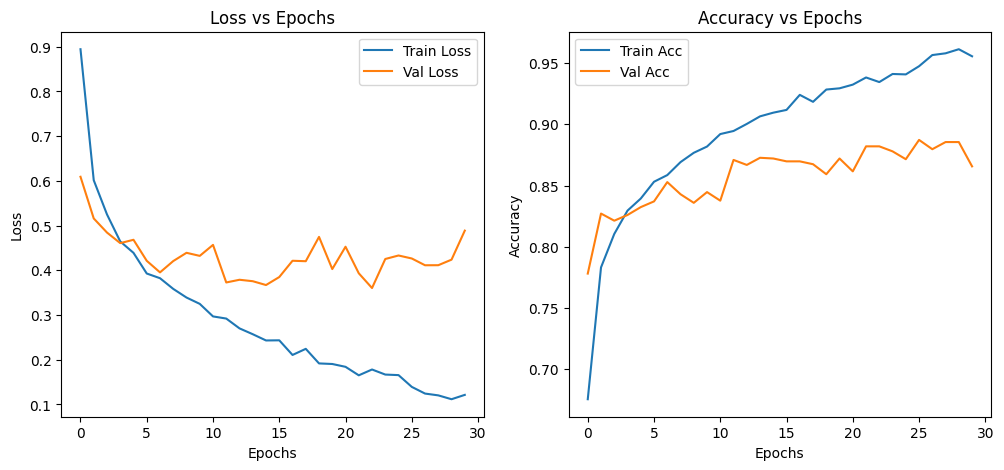

In [10]:
# TODO: Plot Training Loss vs Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# TODO: Plot Training Acc vs Validation Acc
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Q4.3: Evaluation and Analysis (5 points)

Test Accuracy: 0.8629


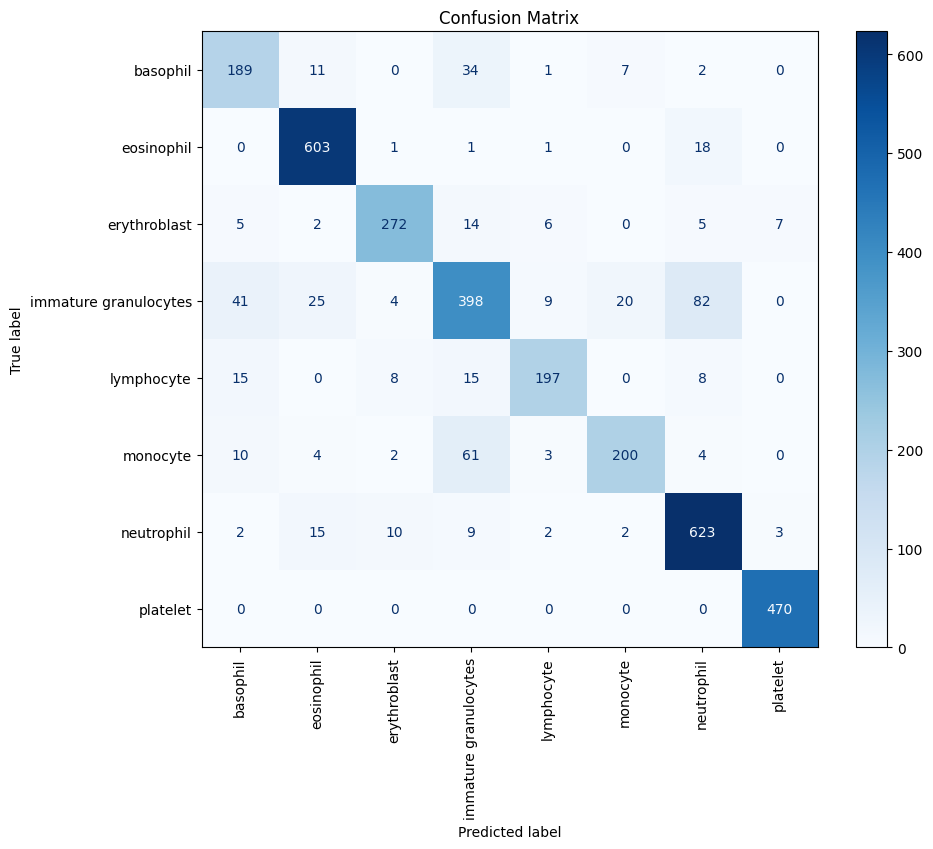

                       precision    recall  f1-score   support

             basophil       0.72      0.77      0.75       244
           eosinophil       0.91      0.97      0.94       624
         erythroblast       0.92      0.87      0.89       311
immature granulocytes       0.75      0.69      0.72       579
           lymphocyte       0.90      0.81      0.85       243
             monocyte       0.87      0.70      0.78       284
           neutrophil       0.84      0.94      0.88       666
             platelet       0.98      1.00      0.99       470

             accuracy                           0.86      3421
            macro avg       0.86      0.84      0.85      3421
         weighted avg       0.86      0.86      0.86      3421



In [11]:
# TODO: Evaluate on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().flatten())

# 1. Accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values())

plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation='vertical', ax=plt.gca(), cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 3. Classification Report
print(classification_report(all_labels, all_preds, target_names=class_labels.values()))

In [12]:
# Identify 2 most confused pairs
np.fill_diagonal(cm, 0)
# Find indices of max values in confusion matrix (flattened)
flattened_cm = cm.flatten()
# Get top 2 indices
top_indices = np.argsort(flattened_cm)[-2:]

# Convert flattened indices back to row/col
row_indices, col_indices = np.unravel_index(top_indices, cm.shape)

print("Top 2 Most Confused Pairs:")
for i in range(2):
    true_class = list(class_labels.values())[row_indices[i]]
    pred_class = list(class_labels.values())[col_indices[i]]
    count = cm[row_indices[i], col_indices[i]]
    print(f"{i+1}. True: {true_class} -> Predicted: {pred_class} (Count: {count})")

# Find class with lowest recall 
report = classification_report(all_labels, all_preds, target_names=class_labels.values(), output_dict=True)
recalls = {cls: metrics['recall'] for cls, metrics in report.items() if cls in class_labels.values()}
lowest_recall_class = min(recalls, key=recalls.get)
lowest_recall_val = recalls[lowest_recall_class]

print(f"\nClass with Lowest Recall: {lowest_recall_class} ({lowest_recall_val:.4f})")

Top 2 Most Confused Pairs:
1. True: monocyte -> Predicted: immature granulocytes (Count: 61)
2. True: immature granulocytes -> Predicted: neutrophil (Count: 82)

Class with Lowest Recall: immature granulocytes (0.6874)


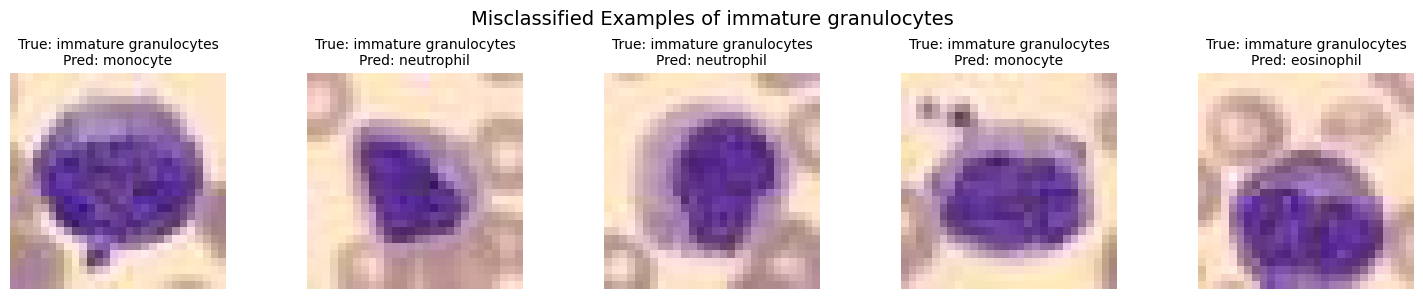

In [13]:
# TODO: Display 5 misclassified examples of the lowest-recall class
lowest_recall_idx = [k for k, v in class_labels.items() if v == lowest_recall_class][0]
lowest_recall_idx = int(lowest_recall_idx)

misclassified_images = []
misclassified_preds = []

# Iterate 
count = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        if count >= 5: break
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Check for specific misclassifications
        mask = (labels.squeeze() == lowest_recall_idx) & (preds != labels.squeeze())
        
        if mask.any():
            idxs = torch.where(mask)[0]
            for idx in idxs:
                if count >= 5: break
                img = images[idx].cpu()
                pred = preds[idx].item()
                
                # Denormalize for display
                img = img * 0.5 + 0.5
                misclassified_images.append(img)
                misclassified_preds.append(pred)
                count += 1

# Plot
plt.figure(figsize=(15, 3))
for i in range(len(misclassified_images)):
    plt.subplot(1, 5, i+1)
    img = misclassified_images[i].permute(1, 2, 0)
    plt.imshow(img)
    pred_name = class_labels[str(misclassified_preds[i])]
    plt.title(f"True: {lowest_recall_class}\nPred: {pred_name}", fontsize=10)
    plt.axis('off')
plt.suptitle(f"Misclassified Examples of {lowest_recall_class}", fontsize=14)
plt.tight_layout()
plt.show()

### Q4.4: Prediction Confidence Analysis (3 points)

Categorize predictions into:
*   Confident & Correct (> 0.9)
*   Confident & Incorrect (> 0.9)
*   Uncertain & Correct (< 0.6)
*   Uncertain & Incorrect (< 0.6)

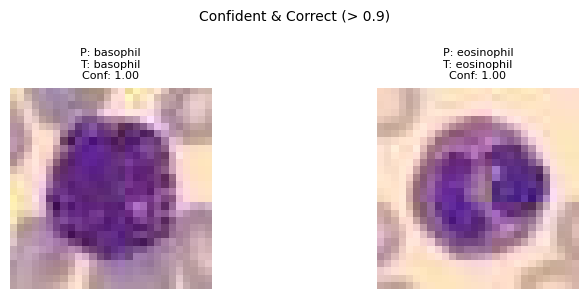

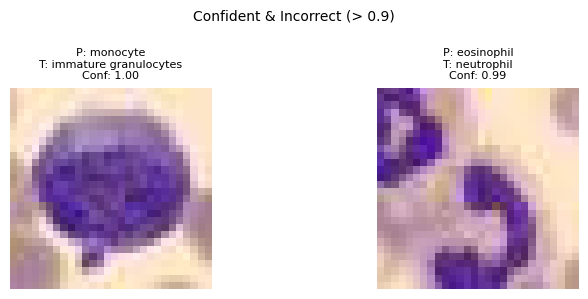

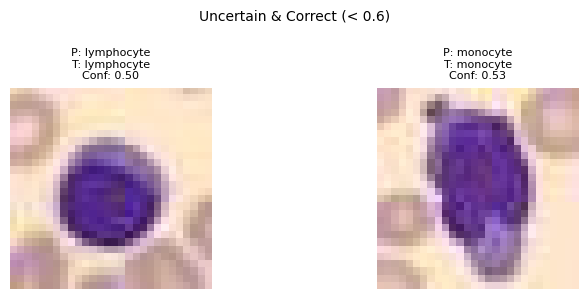

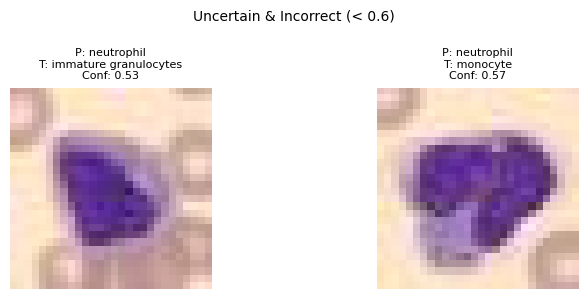

In [14]:
# TODO: Find and display 2 examples from each quadrant
confident_correct = []
confident_incorrect = []
uncertain_correct = []
uncertain_incorrect = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        if len(confident_correct) >= 2 and len(confident_incorrect) >= 2 and \
           len(uncertain_correct) >= 2 and len(uncertain_incorrect) >= 2:
            break
            
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()
        
        outputs = model(images)
        probas = torch.softmax(outputs, dim=1)
        confidences, preds = torch.max(probas, dim=1)
        
        # Check criteria
        for i in range(len(labels)):
            conf = confidences[i].item()
            pred = preds[i].item()
            label = labels[i].item()
            img = images[i].cpu()
            
            # Confident & Correct (> 0.9)
            if conf > 0.9 and pred == label and len(confident_correct) < 2:
                confident_correct.append((img, conf, pred, label))
                
            # Confident & Incorrect (> 0.9)
            elif conf > 0.9 and pred != label and len(confident_incorrect) < 2:
                confident_incorrect.append((img, conf, pred, label))
                
            # Uncertain & Correct (< 0.6)
            elif conf < 0.6 and pred == label and len(uncertain_correct) < 2:
                uncertain_correct.append((img, conf, pred, label))
                
            # Uncertain & Incorrect (< 0.6)
            elif conf < 0.6 and pred != label and len(uncertain_incorrect) < 2:
                uncertain_incorrect.append((img, conf, pred, label))

# Helper
def plot_examples(examples, title):
    if not examples: return
    
    plt.figure(figsize=(8, 3))
    for i, (img, conf, pred, label) in enumerate(examples):
        plt.subplot(1, 2, i+1)
        img = img * 0.5 + 0.5 # Denormalize
        img = img.permute(1, 2, 0)
        plt.imshow(img)
        pred_name = class_labels[str(pred)]
        t = f"P: {pred_name}\nT: {class_labels[str(label)]}\nConf: {conf:.2f}"
        
        # Reduced font size for the label/prediction text
        plt.title(t, fontsize=8) 
        plt.axis('off')
        
    # Reduced font size for the main group title (e.g. "Confident & Correct")
    plt.suptitle(title, fontsize=10) 
    plt.tight_layout()
    plt.show()

# Display
plot_examples(confident_correct, "Confident & Correct (> 0.9)")
if confident_incorrect:
    plot_examples(confident_incorrect, "Confident & Incorrect (> 0.9)")
else:
    print("No 'Confident & Incorrect' examples found.")

if uncertain_correct:
    plot_examples(uncertain_correct, "Uncertain & Correct (< 0.6)")
else:
    print("No 'Uncertain & Correct' examples found.")

if uncertain_incorrect:
    plot_examples(uncertain_incorrect, "Uncertain & Incorrect (< 0.6)")
else:
    print("No 'Uncertain & Incorrect' examples found.")

**Analysis:** What visual characteristics distinguish the "Incorrect but Confident" examples? Why might the model be overconfident?

The "Confident but Incorrect" examples often exhibit misleading features, such as ambiguous shapes. This causes the model to latch onto simple heuristics. The model becomes overconfident because standard cross-entropy training encourages extreme probability outputs (0 or 1) to minimize loss, rather than calibrated uncertainty. This means even a slight resemblance to a learned pattern can trigger a hihg confidence prediction.

--- 
# Problem 5: Weight Initialization and Training Dynamics (15 points)

### Q5.1: Implement Initialization Schemes (3 points)

In [15]:
def initialize_weights(shape, method):
    """
    Args:
        shape: tuple of (fan_in, fan_out)
        method: 'zero', 'small_random', 'xavier', 'he'
    Returns:
        torch.Tensor of initialized weights
    """
    fan_in, fan_out = shape
    
    if method == 'zero':
        return torch.zeros(shape)
    elif method == 'small_random':
        return torch.randn(shape) * 0.01
    elif method == 'xavier':
        # Xavier / Glorot Initialization: N(0, 2 / (fan_in + fan_out))
        std = np.sqrt(2.0 / (fan_in + fan_out))
        return torch.randn(shape) * std
    elif method == 'he':
        # He / Kaiming Initialization: N(0, 2 / fan_in)
        std = np.sqrt(2.0 / fan_in)
        return torch.randn(shape) * std
    else:
        raise ValueError("Unknown method")

### Q5.2: Activation Statistics Before Training (5 points)

Architecture: 784 -> 256 -> 256 -> 256 -> 256 -> 256 -> 10
Activations: Tanh

In [16]:
# TODO: Define a custom MLP class that lets you inspect forward passes
class InitMLP(nn.Module):
    def __init__(self, init_method, activation='tanh'):
        super().__init__()
        self.layers = nn.ModuleList()
        dims = [784, 256, 256, 256, 256, 256, 10]
        self.activation_name = activation

        for i in range(len(dims) - 1):
            layer = nn.Linear(dims[i], dims[i+1])
            # Apply initialization manually
            with torch.no_grad():
                W = initialize_weights((dims[i], dims[i+1]), init_method)
                layer.weight.data = W.T 
                layer.bias.data.zero_()
            self.layers.append(layer)

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)
        activations = []
        
        for i, layer in enumerate(self.layers):
            x = layer(x)

            # Apply activation for hidden layers
            if i < len(self.layers) - 1:
                if self.activation_name == 'tanh':
                    x = torch.tanh(x)
                elif self.activation_name == 'relu':
                    x = torch.relu(x)
                activations.append(x)
            else:
                # Output layer 
                pass
                
        return activations

# TODO: Collect stats (mean/std) for each layer across the 4 init methods
init_methods = ['zero', 'small_random', 'xavier', 'he']
stats = {m: {'means': [], 'stds': []} for m in init_methods}
stats_steps = []

loader = DataLoader(mnist_train, batch_size=256, shuffle=True)
images, _ = next(iter(loader))
images = images.to(device)

for method in init_methods:
    model = InitMLP(method, activation='tanh').to(device)
    with torch.no_grad():
        activations = model(images)
        
    for act in activations:
        stats[method]['means'].append(act.mean().item())
        stats[method]['stds'].append(act.std().item())

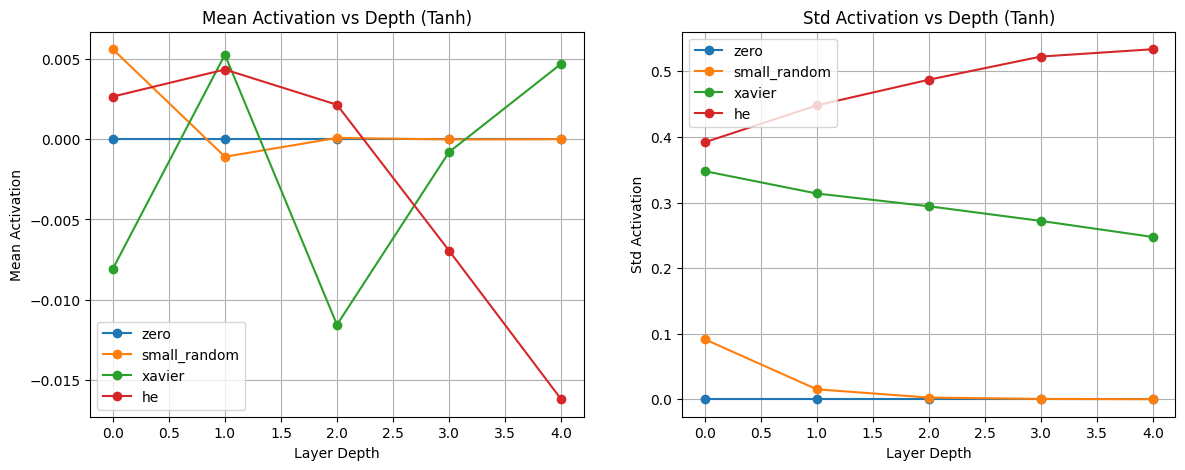

In [17]:
# TODO: Plot Mean Activation vs Depth (subplot 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for method in init_methods:
    plt.plot(stats[method]['means'], label=method, marker='o')
plt.title('Mean Activation vs Depth (Tanh)')
plt.xlabel('Layer Depth')
plt.ylabel('Mean Activation')
plt.legend()
plt.grid(True)

# TODO: Plot Std Activation vs Depth (subplot 2)
plt.subplot(1, 2, 2)
for method in init_methods:
    plt.plot(stats[method]['stds'], label=method, marker='o')
plt.title('Std Activation vs Depth (Tanh)')
plt.xlabel('Layer Depth')
plt.ylabel('Std Activation')
plt.legend()
plt.grid(True)

plt.show()

**Analysis:** Which methods show vanishing/exploding gradients?

He initialization shows a vanishing gradient while xavier shows an exploding gradient.

### Q5.3: Training Dynamics Comparison (4 points)

Train 4 networks (one per init) for 10 epochs on MNIST.

Training with zero initialization (Tanh)...
  Final Test Acc: 0.1135
Training with small_random initialization (Tanh)...
  Final Test Acc: 0.1135
Training with xavier initialization (Tanh)...
  Final Test Acc: 0.9593
Training with he initialization (Tanh)...
  Final Test Acc: 0.9729


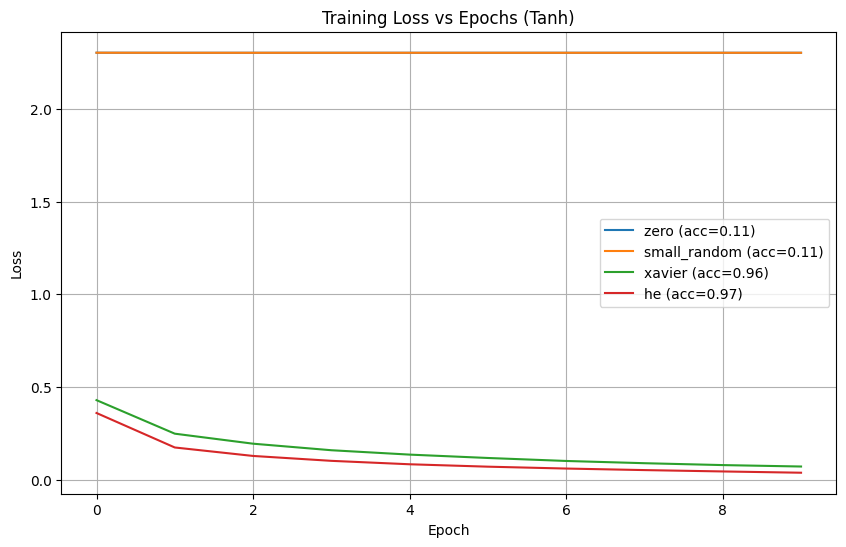

In [18]:
# TODO: Training loop for the 4 models
training_losses = {m: [] for m in init_methods}
final_accuracies = {}
num_epochs = 10
test_loader_mnist = DataLoader(mnist_test, batch_size=256, shuffle=False)

for method in init_methods:
    print(f"Training with {method} initialization (Tanh)...")
    model = InitMLP(method, activation='tanh').to(device)
    optimizer = optim.SGD(model.layers.parameters(), lr=0.1) # Optimize layers directly
    criterion = nn.CrossEntropyLoss()
    
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        batches = 0
        
        for imgs, lbls in loader: 
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            
            # Manual forward for training 
            x = imgs.view(imgs.size(0), -1)
            for i, layer in enumerate(model.layers):
                x = layer(x)
                if i < len(model.layers) - 1:
                    x = torch.tanh(x)
            logits = x
            
            loss = criterion(logits, lbls)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batches += 1
        
        losses.append(epoch_loss / batches)
    
    training_losses[method] = losses

    # Final test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, lbls in test_loader_mnist:
            imgs, lbls = imgs.to(device), lbls.to(device)
            x = imgs.view(imgs.size(0), -1)
            for i, layer in enumerate(model.layers):
                x = layer(x)
                if i < len(model.layers) - 1:
                    x = torch.tanh(x)
            predicted = torch.argmax(x, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()
            
    final_accuracies[method] = correct / total
    print(f"  Final Test Acc: {final_accuracies[method]:.4f}")

# Plot training loss curves
plt.figure(figsize=(10, 6))
for method in init_methods:
    plt.plot(training_losses[method], label=f"{method} (acc={final_accuracies[method]:.2f})")
plt.title("Training Loss vs Epochs (Tanh)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Q5.4: ReLU Activation Experiment (3 points)

Repeat Q5.2 and Q5.3 with **ReLU** instead of Tanh.

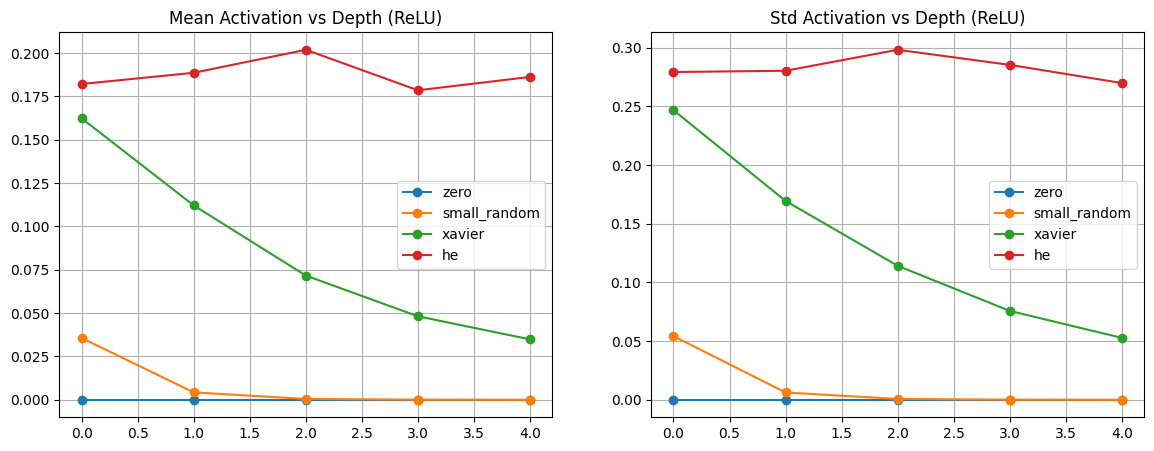

Training with zero initialization (ReLU)...
  Final Test Acc: 0.1135
Training with small_random initialization (ReLU)...
  Final Test Acc: 0.1135
Training with xavier initialization (ReLU)...
  Final Test Acc: 0.9759
Training with he initialization (ReLU)...
  Final Test Acc: 0.9450


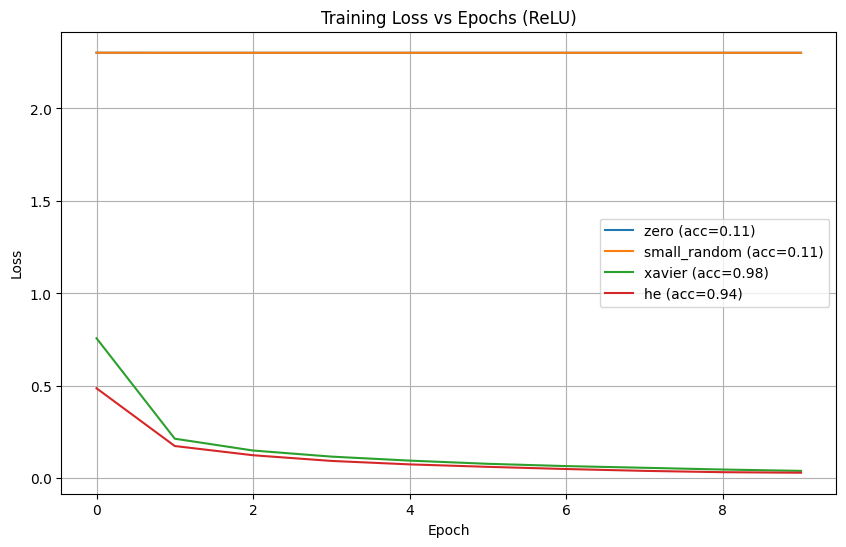

In [19]:
# TODO: Activation statistics with ReLU
stats_relu = {m: {'means': [], 'stds': []} for m in init_methods}
images, _ = next(iter(loader))
images = images.to(device)

for method in init_methods:
    model = InitMLP(method, activation='relu').to(device)
    with torch.no_grad():
        activations = model(images)
        
    for act in activations:
        stats_relu[method]['means'].append(act.mean().item())
        stats_relu[method]['stds'].append(act.std().item())

# Plot ReLU Stats
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for method in init_methods:
    plt.plot(stats_relu[method]['means'], label=method, marker='o')
plt.title('Mean Activation vs Depth (ReLU)')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
for method in init_methods:
    plt.plot(stats_relu[method]['stds'], label=method, marker='o')
plt.title('Std Activation vs Depth (ReLU)')
plt.legend(); plt.grid(True)
plt.show()

# TODO: Training comparison with ReLU
training_losses_relu = {m: [] for m in init_methods}
final_accuracies_relu = {}

for method in init_methods:
    print(f"Training with {method} initialization (ReLU)...")
    model = InitMLP(method, activation='relu').to(device)
    optimizer = optim.SGD(model.layers.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()
    
    losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        batches = 0
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            
            x = imgs.view(imgs.size(0), -1)
            for i, layer in enumerate(model.layers):
                x = layer(x)
                if i < len(model.layers) - 1:
                    x = torch.relu(x)
            logits = x
            
            loss = criterion(logits, lbls)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batches += 1
        losses.append(epoch_loss / batches)
    
    training_losses_relu[method] = losses
    
    # Eval
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for imgs, lbls in test_loader_mnist:
            imgs, lbls = imgs.to(device), lbls.to(device)
            x = imgs.view(imgs.size(0), -1)
            for i, layer in enumerate(model.layers):
                x = layer(x)
                if i < len(model.layers) - 1:
                    x = torch.relu(x)
            predicted = torch.argmax(x, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()
    final_accuracies_relu[method] = correct / total
    print(f"  Final Test Acc: {final_accuracies_relu[method]:.4f}")

# Plot ReLU Training Curves
plt.figure(figsize=(10, 6))
for method in init_methods:
    plt.plot(training_losses_relu[method], label=f"{method} (acc={final_accuracies_relu[method]:.2f})")
plt.title("Training Loss vs Epochs (ReLU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**Analysis:** Compare Tanh vs ReLU dynamics and best initialization methods.

Tanh activations work best with Xavier initialization, which maintains a variance of activations across layers, preventing signals from vanishing or exploding. However, Tanh is prone to vanishing gradients if weights are too large. In contrast, ReLU activations are generally superior for deep networks because they do not have vanishing gradients for positive values, accelerating convergence. ReLU pairs best with He initialization, which accounts for the fact that ReLU zeroes out half the neurons by using a slightly larger variance than Xavier. Using Xavier with ReLU can lead to signal decay (vanishing gradients) in deep networks, while using He with Tanh can lead to saturation.

--- 
# Problem 6: Building a Neural Network Library (25 points)

You will implement `mytorch` in the provided auxiliary files and then use it here.

In [20]:
# Add current directory to path so we can import mytorch
import sys
import os
sys.path.append(os.getcwd())

import mytorch.nn as nn
import mytorch.utils as utils

### Q6.1 - Q6.5: Implementation

Please implement the classes in:
1.  `mytorch/nn/modules/linear.py`
2.  `mytorch/nn/modules/activation.py`
3.  `mytorch/nn/modules/loss.py`
4.  `mytorch/nn/sequential.py`
5.  `mytorch/nn/optim.py`

*(Editor's note: You should edit these files directly.)*

### Q6.6: Gradient Checking (3 points)

In [21]:
from mytorch.utils import gradient_check

# Create a small dummy network for checking
input_size = 5
hidden_size = 10
output_size = 3
batch_size = 4

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

loss_fn = nn.SoftmaxCrossEntropy()

# Random data
x_dummy = np.random.randn(batch_size, input_size)
y_dummy = np.eye(output_size)[np.random.choice(output_size, batch_size)]

# Check gradients
try:
    error = gradient_check(model, loss_fn, x_dummy, y_dummy)
    print(f"Gradient check Max Relative Error: {error:.2e}")
    if error < 1e-5:
        print("Gradient check PASSED!")
    else:
        print("Gradient check FAILED!")
except NotImplementedError:
    print("Gradient check not implemented yet.")

Gradient check Max Relative Error: 4.02e-09
Gradient check PASSED!


### Q6.7: Train and Evaluate on MNIST (4 points)

Loading MNIST data for mytorch...
Train shape: (60000, 784), Test shape: (10000, 784)
Starting training...
Epoch 1/3 - Loss: 0.3775
Epoch 2/3 - Loss: 0.1765
Epoch 3/3 - Loss: 0.1312


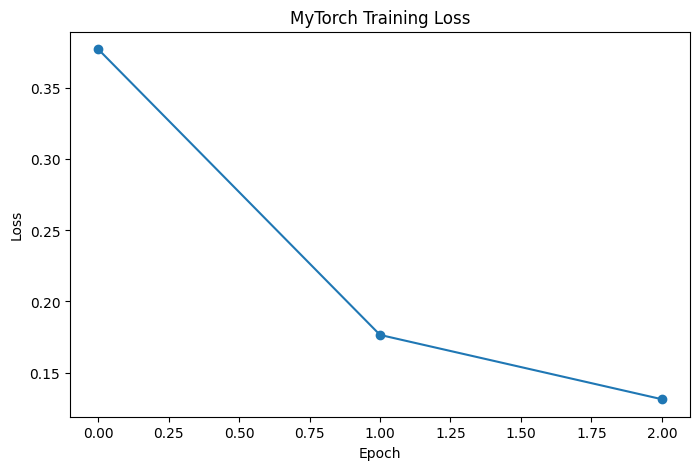

Test Accuracy: 0.9641


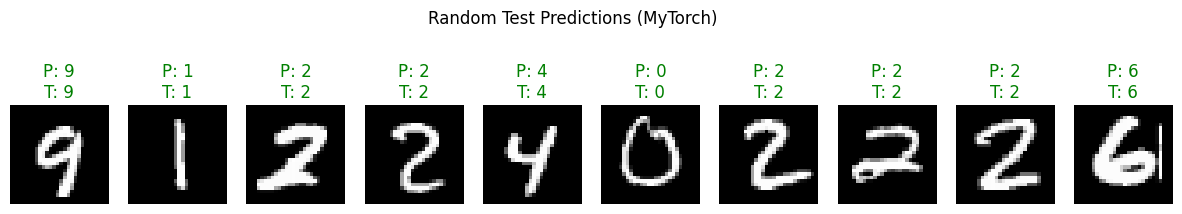

In [ ]:
# TODO: Train on MNIST using mytorch
# Re-load data to ensure we have the full training set as numpy arrays
def get_numpy_data(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    X, y = next(iter(loader))
    X = X.view(X.size(0), -1).numpy() # Flatten to (N, 784)
    y = y.numpy()
    return X, y

print("Loading MNIST data for mytorch...")
X_train, y_train = get_numpy_data(mnist_train)
X_test, y_test = get_numpy_data(mnist_test)

# 2. Create model: 784 -> 128 (ReLU) -> 64 (ReLU) -> 10
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

# 3. Optimizer: SGD(lr=0.1)
optimizer = nn.SGD(model, lr=0.1)

# 4. Loss: SoftmaxCrossEntropy
criterion = nn.SoftmaxCrossEntropy()

# 5. Train for 3 epochs
num_epochs = 3
batch_size = 64 # PDF Requirement
num_batches = X_train.shape[0] // batch_size
losses = []

print(f"Starting training for {num_epochs} epochs with batch size {batch_size}...")

for epoch in range(num_epochs):
    # Shuffle data
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    epoch_loss = 0.0
    
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        
        # Forward
        logits = model.forward(X_batch)
        loss = criterion.forward(logits, y_batch)
        
        # Backward
        dLdy = criterion.backward()
        model.backward(dLdy)
        
        # Optimize
        optimizer.step()
        
        epoch_loss += loss
        
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o')
plt.title("MyTorch Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Report test accuracy
# Process in batches to avoid memory issues if needed, though MNIST is small enough
logits_test = model.forward(X_test)
preds_test = np.argmax(logits_test, axis=1)
accuracy = np.mean(preds_test == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Display 10 random test predictions
indices = np.random.choice(X_test.shape[0], 10, replace=False)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28, 28)
    pred = preds_test[idx]
    true = y_test[idx]
    
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"P: {pred}\nT: {true}", color=('green' if pred==true else 'red'))
    plt.axis('off')
plt.suptitle("Random Test Predictions (MyTorch)")
plt.show()